# Neural Computation - 2021

# Tutorial - Generative Adversarial Networks (GANs)

**Aims of this tutorial**:
- Implement and train a Generative Adversarial Network (GAN) in Pytorch.
- Generate new data by drawing samples from GAN.

**Prerequisites**:
- Familiar with python, numpy, and basic PyTorch.
- Familiar with MNIST and Multi-Layer-Perceptrons (MLPs).


**Notes**:
- Docs for Pytorch's functions you will need:  
https://pytorch.org/docs/stable/tensors.html  
https://pytorch.org/docs/stable/nn.html  
- Some helper functions for loading and plotting data are given in `./utils` folder. They will be used out of the box below.

## Preliminary: Loading and refreshing MNIST

Loading and inspecting MNIST data. Same as previous tutorial...

In [1]:
# -*- coding: utf-8 -*-
# The below is for auto-reloading external modules after they are changed, such as those in ./utils.
# Issue: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import numpy as np
from utils.data_utils import get_mnist # Helper function. Use it out of the box.

# Constants
DATA_DIR = './data/mnist' # Location we will keep the data.
SEED = 111111

# If datasets are not at specified location, they will be downloaded.
train_imgs, train_lbls = get_mnist(data_dir=DATA_DIR, train=True, download=True)
test_imgs, test_lbls = get_mnist(data_dir=DATA_DIR, train=False, download=True)

print("[train_imgs] Type: ", type(train_imgs), "|| Shape:", train_imgs.shape, "|| Data type: ", train_imgs.dtype )
print("[train_lbls] Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, "|| Data type: ", train_lbls.dtype )
print('Class labels in train = ', np.unique(train_lbls))

print("[test_imgs] Type: ", type(test_imgs), "|| Shape:", test_imgs.shape, " || Data type: ", test_imgs.dtype )
print("[test_lbls] Type: ", type(test_lbls), "|| Shape:", test_lbls.shape, " || Data type: ", test_lbls.dtype )
print('Class labels in test = ', np.unique(test_lbls))

N_tr_imgs = train_imgs.shape[0] # N hereafter. Number of training images in database.
H_height = train_imgs.shape[1] # H hereafter
W_width = train_imgs.shape[2] # W hereafter
C_classes = len(np.unique(train_lbls)) # C hereafter

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:04<00:00, 1986651.61it/s]


Extracting ./data/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./data/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 260324.36it/s]


Extracting ./data/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1325716.43it/s]


Extracting ./data/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/mnist\MNIST\raw

[train_imgs] Type:  <class 'numpy.ndarray'> || Shape: (60000, 28, 28) || Data type:  uint8
[train_lbls] Type:  <class 'numpy.ndarray'> || Shape: (60000,) || Data type:  int16
Class labels in train =  [0 1 2 3 4 5 6 7 8 9]
[test_imgs] Type:  <class 'numpy.ndarray'> || Shape: (10000, 28, 28)  || Data type:  uint8
[test_lbls] Type:  <class 'numpy.ndarray'> || Shape: (10000,)  || Data type:  int16
Class labels in test =  [0 1 2 3 4 5 6 7 8 9]


Above we see that data have been loaded in *numpy arrays*.    
Arrays with images have **shape ( N = number of images, H = height, W = width )**.  
Arrays with labels have **shape ( N = number of images)**, holding one integer per image, the digit's class.

MNIST comprises of a **train set (N_tr = 60000) images** and a **test set (N_te = 10000) images**.  
We will use the train set for unsupervised learning. The test set will only be used for evaluating generalisation of classifiers towards the end of the tutorial.

Lets plot a few image in one collage to have a look...

n_rows= 10


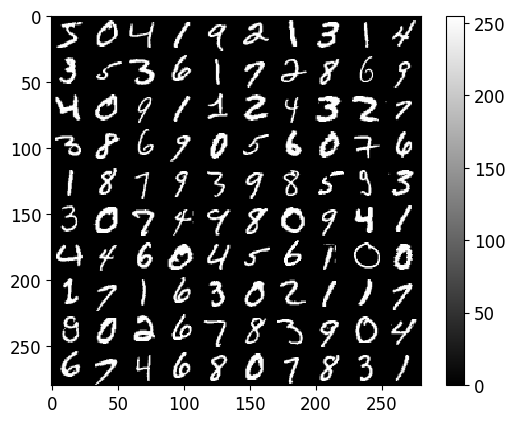

In [2]:
%matplotlib inline
from utils.plotting import plot_grid_of_images # Helper functions, use out of the box.
plot_grid_of_images(train_imgs[0:100], n_imgs_per_row=10)

Notice that the intensities in the images take **values from 0 to 255**.

## Preliminary: Data pre-processing

A first step in almost all pipelines is to pre-process the data, to make them more appropriate for a model.

Below, we will perform 3 points:  
a) Change the labels from an integer representation to a **one-hot representation** of the **C=10 classes**.\
b) Re-scale the **intensities** in the images, from the range \[0,255\], to be instead in the range \[-1,+1\].\
c) **Vectorise the 2D images into 1D vectors for the MLP**, which only gets vectors as input.

In [3]:
# a) Change representation of labels to one-hot vectors of length C=10.
train_lbls_onehot = np.zeros(shape=(train_lbls.shape[0], C_classes ) )
train_lbls_onehot[ np.arange(train_lbls_onehot.shape[0]), train_lbls ] = 1
test_lbls_onehot = np.zeros(shape=(test_lbls.shape[0], C_classes ) )
test_lbls_onehot[ np.arange(test_lbls_onehot.shape[0]), test_lbls ] = 1
print("BEFORE: [train_lbls]        Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, " || Data type: ", train_lbls.dtype )
print("AFTER : [train_lbls_onehot] Type: ", type(train_lbls_onehot), "|| Shape:", train_lbls_onehot.shape, " || Data type: ", train_lbls_onehot.dtype )

BEFORE: [train_lbls]        Type:  <class 'numpy.ndarray'> || Shape: (60000,)  || Data type:  int16
AFTER : [train_lbls_onehot] Type:  <class 'numpy.ndarray'> || Shape: (60000, 10)  || Data type:  float64


Plotting image of index: [ 0 ]
Class label for this image is:  5
One-hot label representation: [ [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] ]


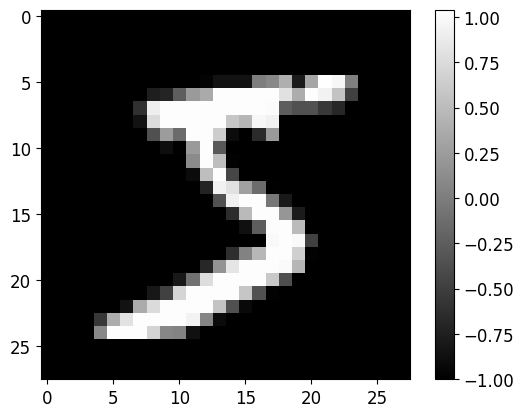

In [4]:
# b) Re-scale image intensities, from [0,255] to [-1, +1].
# This commonly facilitates learning:
# A zero-centered signal with small magnitude allows avoiding exploding/vanishing problems easier.
from utils.data_utils import normalize_int_whole_database # Helper function. Use out of the box.
train_imgs = normalize_int_whole_database(train_imgs, norm_type="minus_1_to_1")
test_imgs = normalize_int_whole_database(test_imgs, norm_type="minus_1_to_1")

# Lets plot one image.
from utils.plotting import plot_image, plot_images # Helper function, use out of the box.
index = 0  # Try any, up to 60000
print("Plotting image of index: [", index, "]")
print("Class label for this image is: ", train_lbls[index])
print("One-hot label representation: [", train_lbls_onehot[index], "]")
plot_image(train_imgs[index])
# Notice the magnitude of intensities. Black is now negative and white is positive float.
# Compare with intensities of figure further above.

In [5]:
# c) Flatten the images, from 2D matrices to 1D vectors. MLPs take feature-vectors as input, not 2D images.
train_imgs_flat = train_imgs.reshape([train_imgs.shape[0], -1]) # Preserve 1st dim (S = num Samples), flatten others.
test_imgs_flat = test_imgs.reshape([test_imgs.shape[0], -1])
print("Shape of numpy array holding the training database:")
print("Original : [N, H, W] = [", train_imgs.shape , "]")
print("Flattened: [N, H*W]  = [", train_imgs_flat.shape , "]")

Shape of numpy array holding the training database:
Original : [N, H, W] = [ (60000, 28, 28) ]
Flattened: [N, H*W]  = [ (60000, 784) ]


## Task 1: Implementing a GAN

In this task, you are called to implement the architecture and losses of a Generative Adversarial Network.
Make necessary modifications where requested, to create the below architecture:

![title](./documentation/gan_arch.png)


In [6]:
# -*- coding: utf-8 -*-
import torch
import torch.optim as optim
import torch.nn as nn

lrelu = nn.LeakyReLU(0.2)

class Network():
    
    def backward_pass(self, loss):
        # Performs back propagation and computes gradients
        # With PyTorch, we do not need to compute gradients analytically for parameters were requires_grads=True, 
        # Calling loss.backward(), torch's Autograd automatically computes grads of loss wrt each parameter p,...
        # ... and **puts them in p.grad**. Return them in a list.
        loss.backward()
        grads = [param.grad for param in self.params]
        return grads
    
class Generator(Network):
    def __init__(self, rng, D_z, D_hid1, D_hid2, D_data):
        self.D_z = D_z  # Keep track of it, we may need it.
        # Initialize weight matrices
        # Dimensions of parameter tensors are (number of neurons + 1) per layer, to account for +1 bias.
        # First 2 hidden layers
        w1_init = rng.normal(loc=0.0, scale=np.sqrt(2./(D_z * D_hid1)), size=(D_z + 1, D_hid1))
        w2_init = rng.normal(loc=0.0, scale=np.sqrt(2./(D_hid1 * D_hid2)), size=(D_hid1 + 1, D_hid2))
        # -- Output layer, predicting p(real|x)
        wout_init = rng.normal(loc=0.0, scale=np.sqrt(2./(D_hid2 * D_data)), size=(D_hid2 + 1, D_data))

        
        # Pytorch tensors, parameters of the model
        # Use the above numpy arrays as of random floats as initialization for the Pytorch weights.
        w1 = torch.tensor(w1_init, dtype=torch.float, requires_grad=True)
        w2 = torch.tensor(w2_init, dtype=torch.float, requires_grad=True)
        wout = torch.tensor(wout_init, dtype=torch.float, requires_grad=True)
        
        # Keep track of all trainable parameters:
        self.params = [w1, w2, wout]
        
        
    def forward(self, batch_z):
        # z_codes: numpy array or pytorch tensor, shape [N, dimensionality of data]
        [w1, w2, wout] = self.params
        # make numpy to pytorch tensor
        batch_z_t = torch.tensor(batch_z, dtype=torch.float) if type(batch_z) is np.ndarray else batch_z
        # add 1 element for bias
        unary_feature_for_bias = torch.ones(size=(batch_z_t.shape[0], 1))  # [N, 1] column vector.
        
        # ========== TODO: Fill in the gaps ======== d
        # hidden layer:
        z_ext = torch.cat((batch_z_t, unary_feature_for_bias), dim=1)
        h1_preact = z_ext.mm(w1) # <--------------------
        h1_act = lrelu(h1_preact)  
        # l2
        h1_ext = torch.cat((h1_act, unary_feature_for_bias), dim=1)
        h2_preact = h1_ext.mm(w2) # <------------- 
        h2_act = lrelu(h2_preact)
        # output layer.
        h2_ext = torch.cat((h2_act, unary_feature_for_bias), dim=1)
        hout_preact = h2_ext.mm(wout)  # <-----------
        hout_act = torch.tanh(hout_preact)  # Choose output activation function for G. See what used in VAE 
        # ==========================================
        
        # Output
        x_generated = hout_act  # [N_samples, dimensionality of data]
        
        return x_generated
                        
        
class Discriminator(Network):
    def __init__(self, rng, D_data, D_hid1, D_hid2):
        # Initialize weight matrices
        # Dimensions of parameter tensors are (number of neurons + 1) per layer, to account for +1 bias.
        # -- 2 hidden layers
        w1_init = rng.normal(loc=0.0, scale=np.sqrt(2. / (D_data * D_hid1)), size=(D_data + 1, D_hid1))
        w2_init = rng.normal(loc=0.0, scale=np.sqrt(2. / (D_hid1 * D_hid2)), size=(D_hid1 + 1, D_hid2))
        # -- Output layer, predicting p(real|x)
        wout_init = rng.normal(loc=0.0, scale=np.sqrt(2. / D_hid2), size=(D_hid2 + 1, 1))
        
        # Pytorch tensors, parameters of the model
        # Use the above numpy arrays as of random floats as initialization for the Pytorch weights.
        w1 = torch.tensor(w1_init, dtype=torch.float, requires_grad=True)
        w2 = torch.tensor(w2_init, dtype=torch.float, requires_grad=True)
        wout = torch.tensor(wout_init, dtype=torch.float, requires_grad=True)
        
        # Keep track of all trainable parameters:
        self.params = [w1, w2, wout]
        
        
    def forward(self, batch_x):
        # z_codes: numpy array or pytorch tensor, shape [N, dimensionality of data]
        [w1, w2, wout] = self.params
        # make numpy to pytorch tensor
        batch_x_t = torch.tensor(batch_x, dtype=torch.float) if type(batch_x) is np.ndarray else batch_x
        # Add 1 element or bias
        unary_feature_for_bias = torch.ones(size=(batch_x_t.shape[0], 1)) # [N, 1] column vector.
        
        # ========== TODO: Fill in the gaps ======== d
        # hidden layer:
        x_ext = torch.cat((batch_x_t, unary_feature_for_bias), dim=1)
        h1_preact = x_ext.mm(w1)   #<-----------------
        h1_act = lrelu(h1_preact)
        # layer 2
        h1_ext = torch.cat((h1_act, unary_feature_for_bias), dim=1)
        h2_preact = h1_ext.mm(w2)  # <---------------
        h2_act = lrelu(h2_preact)
        # output layer.
        h2_ext = torch.cat((h2_act, unary_feature_for_bias), dim=1)
        hout_preact = h2_ext.mm(wout)
        hout_act = torch.sigmoid(hout_preact)  # Choose output layer activation function for D. See lecture slides. 
        # ===========================================
        
        # Output
        p_real = hout_act
        
        return p_real
    

def generator_loss_practical(p_generated_x_is_real):
    # mu: Tensor, [number of samples]. Predicted probability D(G(z)) that fake data are real. 
    
    ######## TODO: Complete the gap ########### d
    loss_per_sample = - torch.log(p_generated_x_is_real)  # <------- See slides for the "practical" loss commonly used.
    ###########################################
    expected_loss = torch.mean(loss_per_sample, dim=0)  # Expectation of loss: Mean over samples (axis=0).
    return expected_loss


def discriminator_loss(p_real_x_is_real, p_generated_x_is_real):
    # p_real_x_is_real: [N] Predicted probability D(x) for x~training_data that real data are real. 
    # p_generated_x_is_real: [N]. Predicted probability D(x) for x=G(z) where z~N(0,I) that fake data are real.
    
    ######## TODO: Complete the calculation of Reconstruction loss for each sample ########### d
    loss_per_real_x = - torch.log(p_real_x_is_real)  # <---------------
    exp_loss_reals = torch.mean(loss_per_real_x)
    
    loss_per_fake_x = - torch.log(1 - p_generate_x_is_real)  # <--------------
    exp_loss_fakes = torch.mean(loss_per_fake_x)
    ##########################################################################################
    
    total_loss = exp_loss_reals + exp_loss_fakes  # Expectation of loss: Mean over samples (axis=0).
    return total_loss


If this task is completed correctly, you should be able to run the cell and get no errors. Though no output will be given yet. We will use this in the next task, and then we will find out if everything went well :-)

## Task 2: Implement unsupervised training of a GAN

Below you are given the main training routine for training GANs. This is an implementation of the same Algorithm that was given in the Lecture slides.

In the below code, each training iteration of the whole GAN consists of two stages:\\
**First**, the Discriminator D is trained for a few steps (1 in this implementation, as commonly done). This is done by contrusting two batches, on consisting of real and one of fake examples. The fake examples were created by the Generator G, by decoding randomly sampled z taken from the prior p(z), here a multi-variant gaussian N(0,I). The discriminator processes both batches, and calculates 2 parts for its loss, one for the real and one for the fake examples. The discriminator is then updated by backprop.\\
**Second**, the Generator is updated. This is done by creating a batch of generated samples with G. The batch is given to the discriminator, and the "practical" version of G's loss is computed, as a function of the predicted probabilities of D that the input batch is real. Then, G is updated by backprop to minimize this loss (minimize accuracy of D).

The process is repeated for the chosen amount of steps.

Fill in the blanks in the code. You can consult the corresponding Lecture slides with the pseudo-algorithm for training.

In [ ]:
from utils.plotting import plot_train_progress_GAN, plot_grids_of_images  # Use out of the box


def get_batch_reals(train_imgs, train_lbls, batch_size, rng):
    # train_imgs: Images. Numpy array of shape [N, H * W]
    # train_lbls: Labels of images. None, or Numpy array of shape [N, C_classes], one hot label for each image.
    # batch_size: integer. Size that the batch should have.
    
    indices = range(0, batch_size)  # Remove this line after you fill-in and un-comment the below. 
    indices = rng.randint(low=0, high=train_imgs.shape[0], size=batch_size, dtype='int32')
    
    train_imgs_batch = train_imgs[indices]
    if train_lbls is not None:  # Enables function to be used both for supervised and unsupervised learning
        train_lbls_batch = train_lbls[indices]
    else:
        train_lbls_batch = None
    return [train_imgs_batch, train_lbls_batch]



def unsupervised_training_GAN(generator,
                              discriminator,
                              loss_func_g,
                              loss_func_d,
                              rng,
                              train_imgs_all,
                              batch_size_g,
                              batch_size_d_fakes,
                              batch_size_d_reals,
                              learning_rate_g,
                              learning_rate_d,
                              total_iters_g,
                              inner_iters_d,
                              iters_per_gen_plot=-1):
    # generator: Instance of a Generator.
    # discriminator: Instance of a Discriminator.
    # loss_func_g: Loss functions of G
    # loss_func_d: Loss functions of D
    # rng: numpy random number generator
    # train_imgs_all: All the training images. Numpy array, shape [N_tr, H, W]
    # batch_size_g: Size of the batch for G when it is its turn to get updated.
    # batch_size_d_fakes: Size of batch of fake samples for D when it is its turn to get updated.
    # batch_size_d_reals: Size of batch of real samples for D when it is its turn to get updated.
    # learning_rate_g: Learning rate for G.
    # learning_rate_d: learning rate for D.
    # total_iters_g: how many SGD iterations to perform for G in total (outer loop).
    # inner_iters_d: how many SGD iterations to perform for D before every 1 SGD iteration of G.
    # iters_per_gen_plot: Integer. Every that many iterations the model generates few examples and we plot them.
    loss_g_to_plot = []
    loss_d_to_plot = []
    loss_g_mom_to_plot = []
    loss_d_mom_to_plot = []
    loss_g_mom = None
    loss_d_mom = None
    
    optimizer_g = optim.Adam(generator.params, lr=learning_rate_g, betas=[0.5, 0.999], eps=1e-07, weight_decay=0)  # Will use PyTorch's Adam optimizer out of the box
    optimizer_d = optim.Adam(discriminator.params, lr=learning_rate_d, betas=[0.5, 0.99], eps=1e-07, weight_decay=0)  # Will use PyTorch's Adam optimizer out of the box
    
    for t in range(total_iters_g):
        
        for k in range(inner_iters_d):
            #======== Train Discriminator for inner_iters_d SGD iterations... =========
            
            ################## TODO: Fill in the gaps ####################### d 
            # Generate Fake samples with G
            z_batch = np.random.normal(loc=0., scale=1., size=[batch_size_d_fakes, generator.D_z])
            x_gen_batch = generator.forward(?????????)  # <------------ ???????????
            # Forward pass of fake samples through D
            p_gen_x_are_real = discriminator.forward(x_gen_batch)  # <------------ ???????????
            
            # Forward pass of real samples through D
            x_reals_batch, _ = get_batch_reals(train_imgs_all, None, batch_size_d_reals, rng)
            p_real_x_are_real = discriminator.forward(x_reals_batch)  # <------------ ???????????
            
            # Compute D loss:
            loss_d = loss_func_d(p_real_x_are_real,p_gen_x_are_real)  # <--------------?????
            ####################################################################
            
            # Backprop to D
            optimizer_d.zero_grad()
            _ = discriminator.backward_pass(loss_d)
            optimizer_d.step()
            
        #============ Train Generator for 1 SGD iteration ============
        
        ########## TODO: Fill in the gaps ################################## d
        # Generate Fake samples with G
        z_batch = np.random.normal(loc=0., scale=1., size=[batch_size_g, generator.D_z])
        x_gen_batch = generator.forward(z_batch)  # <---------------------
        # Forward pass of fake samples through D
        p_gen_x_are_real = discriminator.forward(x_gen_batch)  # <---------------
        ####################################################################
        
        # Compute G loss:
        loss_g = loss_func_g(p_gen_x_are_real)
        
        # Backprop to G
        optimizer_g.zero_grad()
        _ = generator.backward_pass(loss_g)
        optimizer_g.step()
        
        # ==== Report training loss and accuracy ======
        loss_g_np = loss_g if type(loss_g) is type(float) else loss_g.item()
        loss_d_np = loss_d if type(loss_d) is type(float) else loss_d.item()
        if t % 10 == 0:  # Print every 10 iterations
            print("[iter:", t, "]: Loss G: {0:.2f}".format(loss_g_np), " Loss D: {0:.2f}".format(loss_d_np))

        loss_g_mom = loss_g_np if loss_g_mom is None else loss_g_mom * 0.9 + 0.1 * loss_g_np
        loss_d_mom = loss_d_np if loss_d_mom is None else loss_d_mom * 0.9 + 0.1 * loss_d_np

        loss_g_to_plot.append(loss_g_np)
        loss_d_to_plot.append(loss_d_np)
        loss_g_mom_to_plot.append(loss_g_mom)
        loss_d_mom_to_plot.append(loss_d_mom)
        
        # =============== Every few iterations, plot loss ================#
        if t == total_iters_g - 1 or t % iters_per_gen_plot == 0:
            
            ########## TODO: Fill in the gaps ############################# d
            # Generate Fake samples with G
            n_samples_to_gen = 100
            z_plot = np.random.normal(loc=0, scale=1, size=[100, generator.D_z])  # <----------- N(0,I)
            x_gen_plot = generator.forward(z_plot)
            ###############################################################
            
            # Cast tensors to numpy arrays
            x_gen_plot_np = x_gen_plot if type(x_gen_plot) is np.ndarray else x_gen_plot.detach().numpy()
            # Generated images have vector shape. Reshape them to original image shape.
            x_gen_plot_resh = x_gen_plot_np.reshape([n_samples_to_gen, H_height, W_width])
            
            train_imgs_resh = train_imgs_all.reshape([train_imgs_all.shape[0], H_height, W_width])
            
            # Plot a few generated images.
            plot_grids_of_images([x_gen_plot_resh[0:100], train_imgs_resh[0:100]],
                                  titles=["Generated", "Real"],
                                  n_imgs_per_row=10,
                                  dynamically=True)
            
    # In the end of the process, plot loss.
    plot_train_progress_GAN(loss_g_to_plot, loss_d_to_plot,
                            loss_g_mom_to_plot, loss_d_mom_to_plot,
                            iters_per_point=1, y_lims=[3., 3.])
    

After filling in the blanks, you should see no errors if you run the above cell. There will be no output yet. We will use the above code below, to actually create and train a GAN.

## Task 3: Instantiate and Train your GAN

The below code will instantiate a Generator and a Discriminator that you implemented above.\\
It will then train the GAN with the training routine you implemented above.

The code is complete. Run it, debug the previous sections if needed, and then observe the results.

In [ ]:
# Create the network
rng = np.random.RandomState(seed=SEED)
generator = Generator(rng=rng,
                      D_z=128,
                      D_hid1=256,
                      D_hid2=512,
                      D_data=H_height*W_width)
discriminator = Discriminator(rng=rng,
                              D_data=H_height*W_width,
                              D_hid1=256,
                              D_hid2=512)

# Start training
unsupervised_training_GAN(generator,
                          discriminator,
                          loss_func_g=generator_loss_practical,
                          loss_func_d=discriminator_loss,
                          rng=rng,
                          train_imgs_all=train_imgs_flat,
                          batch_size_g=32,
                          batch_size_d_fakes=64,
                          batch_size_d_reals=64,
                          learning_rate_g=1e-3,
                          learning_rate_d=1e-3,
                          total_iters_g=5000,
                          inner_iters_d=1,
                          iters_per_gen_plot=100)


The above requires you to have completed both Task 1 and Task 2. If everything is completed correctly, you should see the model getting trained and the total training lossses of G and D printed every few iterations.

In the end of training, after 5000 iterations, you will see 2 plots, one for G and one for D.
You should also see printed side by side a set of random generated images, and some real images for comparison.\

Towards end of training, (some) generated images should start looking relatively realistic.

The loss of D should decrease down to approx 1.0.\\

**Question:**

- The loss of G may not be monotonically decreasing, as we are used to, although it should clearly learn to produce better images during training. Why do you think this happens?

## Task 4: Generate new images using your GAN

After training, we can use the trained Generator to create new images. We simply sample z from the prior and decode it with the Generator (similar to a trained Decoder of a VAE).

The code is complete, simply run it and observe the quality of the results. Hopefully some of them should look reasonable..!

In [ ]:
def synthesize(generator, n_samples):
    
        # Generate Fake samples with G
        z_plot = np.random.normal(loc=0., scale=1., size=[n_samples, generator.D_z])
        x_gen_plot = generator.forward(z_plot)
        # Cast tensors to numpy arrays
        x_gen_plot_np = x_gen_plot if type(x_gen_plot) is np.ndarray else x_gen_plot.detach().numpy()

        # Generated images have vector shape. Reshape them to original image shape.
        x_gen_plot_resh = x_gen_plot_np.reshape([n_samples, H_height, W_width])

        for i in range(n_samples):
            plot_image(x_gen_plot_resh[i])
            
synthesize(generator, 100)

**Questions:**
- Not all generated images will look great, given how small our network is. Regardless, codes z from which part of the prior p(z)=N(0,I) do you think are the  most likely ones to give good results when decoded by the Generator? Why?

**Further experimentation:**

The GAN has **a lot** of hyper-parameters, because we now train 2 neural networks in parallel. Two learning rates, batch sizes, optimizers and their parameters, two architectures (depth, number of neurons, etc) and the choice of all these hyper-parameters needs to be adjusted to achieve good results. The GAN's performance is very sensitive to a good choice of these hyper-parameters. Feel free to experiment by changing the hyper-parameters to get a feel of the challenge in setting-up successful training of GANs.

## This notebook:
Copyright 2021, University of Birmingham  
Tutorial for Neural Computation  
For issues e-mail: k.kamnitsas@bham.ac.uk